In [1]:
import glob
import json
import os

import cv2
from detectron2.engine import DefaultPredictor
import matplotlib.pyplot as plt
import numpy as np

from gametrail_detection import cfg_setup

# local .json file with local path info
ungulates_root = os.path.dirname(os.path.dirname(os.getcwd()))
local_paths_file = os.path.join(ungulates_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])

from mapping_functions import get_image_map

Will throw error if using functions that require gdal.


110 tiles found.


In [1]:
config_file = "detectron2_yamls/deeplab_v3_plus_R_103_os16_mg124_poly_90k_bs16.yaml"
# Download weights before using: https://github.com/facebookresearch/detectron2/tree/main/projects/DeepLab
pretrained_weights = ".../model_final_deeplabv3plus_cityscapes_id28054032.pkl"
cfg = cfg_setup(config_file, pretrained_weights, name="buffer")

# Check training
cfg.defrost()
# Model weights be downloaded from the data repository [link]
cfg.OUTPUT_DIR = ".../full-aug_maxiter-32000_lr-0.00275_detectPerIm-200_minsize-0_batchsize-8"
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 2
cfg.MODEL.SEM_SEG_HEAD.IGNORE_VALUE = 2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("val")
predictor = DefaultPredictor(cfg)

In [5]:
def logit2prob(logit):
    e_l = np.e ** logit
    return e_l / (e_l + 1)

obs_map_file = "observation088_ortho.jpg"
obs_map = cv2.imread(obs_map_file)

(20480, 8192, 3)


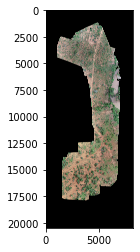

In [6]:
div = 4096
pad = np.pad(obs_map, ((1024, 1024), (1024, 1024), (0,0)), mode="constant")
shape = np.array(pad.shape)
h, w, _ = shape // div + 1
input_map = np.zeros((h*div, w*div, 3), dtype=np.uint8)
input_map[:shape[0], :shape[1]] = pad
plt.imshow(input_map)
print(input_map.shape)

In [7]:
np.array(input_map.shape) / (div/2)

array([1.00000000e+01, 4.00000000e+00, 1.46484375e-03])

In [8]:
tiles = []
step = int(div / 2)
for h_ind in range(int(input_map.shape[0] // step)-1):
    tiles.append([])
    for w_ind in range(int(input_map.shape[1] // step)-1):
        tile = input_map[int(h_ind*step):int(h_ind*step+div), 
                       int(w_ind*step):int(w_ind*step+div),
                       ::-1]
        tiles[-1].append(tile)


In [9]:
trail_probs = np.zeros_like(input_map[...,0], dtype=float)

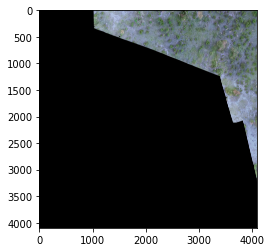

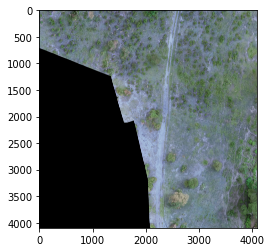

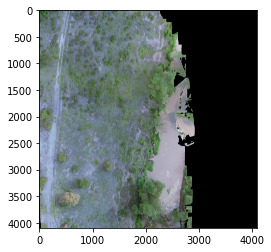

In [10]:
for tile in tiles[2]:
    plt.figure()
    plt.imshow(tile)

In [134]:
height = 4096
width = 4096
upper_left = [1500, 1500]
tiles = [obs_map[upper_left[0]:upper_left[0]+height, 
                 upper_left[1]:upper_left[1]+width,
                 ::-1]]

tiles = [input_map[...,::-1]]

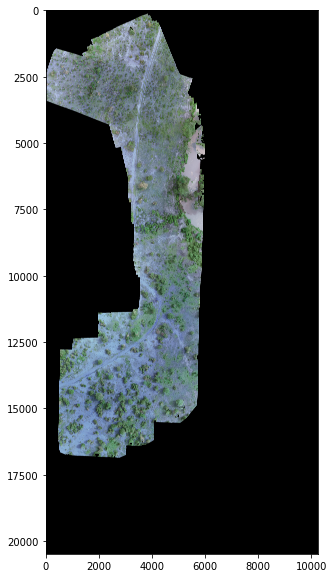

In [135]:
plt.figure(figsize=(10,10))
plt.imshow(tiles[0])

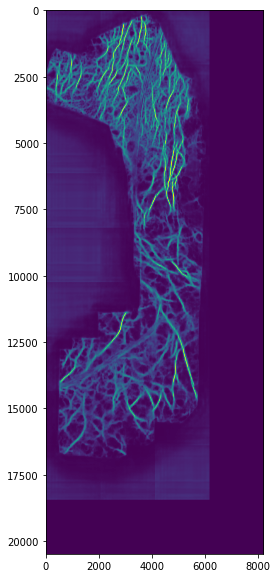

In [11]:
for row_ind, tile_row in enumerate(tiles):
    for col_ind, tile in enumerate(tile_row):
        outputs = predictor(tile)
        sem_seg = outputs["sem_seg"].to("cpu")
        prob_path = logit2prob(sem_seg[1]).numpy()
#         prob_path = tile
        middle = prob_path[int(div/4):-int(div/4), int(div/4):-int(div/4)]
        n_min = int(row_ind * step)
        n_max = int(row_ind * step + step)
        m_min = int(col_ind * step)
        m_max = int(col_ind * step + step)
        trail_probs[n_min:n_max, m_min:m_max] = middle
#     break
plt.figure(figsize=(10,10))
plt.imshow(trail_probs)

In [12]:
trail_probs = trail_probs[:obs_map.shape[0], :obs_map.shape[1]]

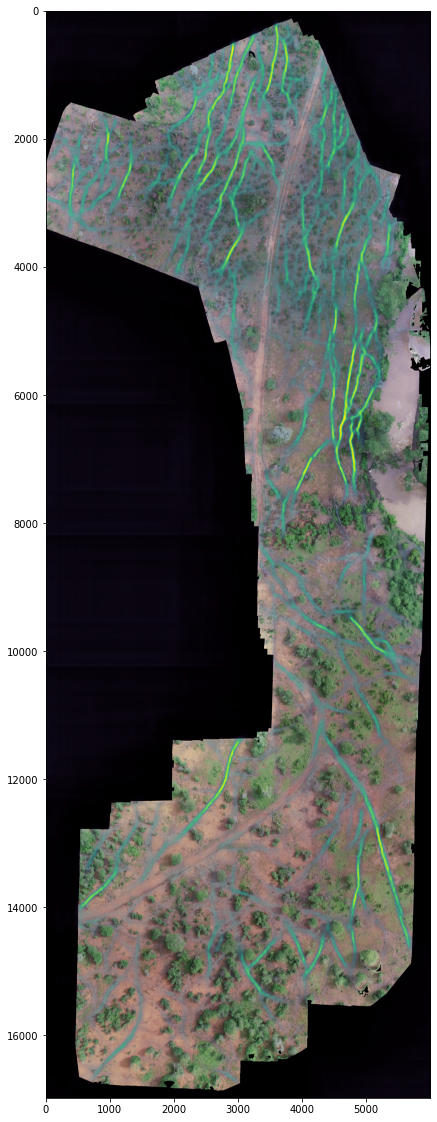

In [15]:
# trail_probs = np.where(trail_probs < .2, 0, trail_probs)
plt.figure(figsize=(20,20))
trail_alpha = trail_probs * 1.5
trail_alpha = np.where(trail_alpha > 1, 1, trail_alpha)
plt.imshow(obs_map)
plt.imshow(trail_probs, alpha=trail_alpha)
plt.savefig("observation088_gametrail_overelay.jpg", dpi=300, bbox_inches='tight')

In [238]:
np.save("observation088_trail_probs.npy", trail_probs)